In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import  spdiags
from icecream import ic
from erfgau import ErfgauPotential
import timeit
from fdm import *
erfgau = ErfgauPotential()
from scipy.signal import convolve



In [33]:
n = 51
x_min = -15
x_max = 15
order = 6




L, x, y, z = fdm_laplacian_3d(x_min, x_max, n, order=order)

V = erfgau.potential(x, y, z)

H = -0.5 * L + spdiags(V, 0, len(x), len(x))


psi = np.exp(-(x*x+y*y+z*z)**.5)
psi /= np.linalg.norm(psi)


In [34]:
psi_grid = psi.reshape((n,n,n))

In [35]:
apply_hamiltonian_sparse = lambda v: H.dot(v)


L1, x0 = fdm_laplacian_1d(x_min, x_max, n, order=order)
L1 *= -.5

def apply_hamiltonian_as_matrix(psi_grid):
    psi_grid2 = np.apply_along_axis(lambda x: L1.dot(x), axis=0, arr=psi_grid)
    psi_grid2 += np.apply_along_axis(lambda x: L1.dot(x), axis=1, arr=psi_grid)
    psi_grid2 += np.apply_along_axis(lambda x: L1.dot(x), axis=2, arr=psi_grid)
    #psi_grid2 *= -0.5
    psi_grid2 += V_grid * psi_grid
    return psi_grid2


def apply_hamiltonian_as_matrix_alt(psi_grid):
    temp = psi_grid.reshape((n, n*n))
    psi_grid2 = L1.dot(temp).reshape((n,n,n))
    temp = psi_grid.swapaxes(0,1).reshape((n, n*n))
    psi_grid2 += L1.dot(temp).reshape((n,n,n)).swapaxes(0,1)
    temp = psi_grid.swapaxes(0,2).reshape((n, n*n))
    psi_grid2 += L1.dot(temp).reshape((n,n,n)).swapaxes(0,2)
    #psi_grid2 *= -0.5
    psi_grid2 += V_grid * psi_grid
    
    return psi_grid2

V_grid = V.reshape((n,n,n))

K = fdm_laplacian_conv_kernel_3d(x_min, x_max, n, order=order)

def apply_hamiltonian_convolve(psi_grid):
    psi_grid2 = convolve(psi_grid, -0.5*K, mode='same')
    psi_grid = V_grid * psi_grid + psi_grid2
    return psi_grid

ic(timeit.timeit(lambda:  apply_hamiltonian_as_matrix_alt(psi_grid), number=10))
ic(timeit.timeit(lambda:  apply_hamiltonian_as_matrix(psi_grid), number=10))
ic(timeit.timeit(lambda:  apply_hamiltonian_convolve(psi_grid), number=10))
ic(timeit.timeit(lambda:  apply_hamiltonian_sparse(psi), number=10))

ic| timeit.timeit(

lambda:  apply_hamiltonian_as_matrix_alt(psi_grid), number=10): 0.020006584003567696
ic| timeit.timeit(lambda:  apply_hamiltonian_as_matrix(psi_grid), number=10): 0.2983177920104936
ic| timeit.timeit(lambda:  apply_hamiltonian_convolve(psi_grid), number=10): 0.03707329195458442
ic| timeit.timeit(lambda:  apply_hamiltonian_sparse(psi), number=10): 0.01312758307904005


0.01312758307904005

In [36]:
Hpsi_sparse = apply_hamiltonian_sparse(psi)
Hpsi_matrix_alt = apply_hamiltonian_as_matrix_alt(psi_grid)
Hpsi_matrix = apply_hamiltonian_as_matrix(psi_grid)
Hpsi_convolve = apply_hamiltonian_convolve(psi_grid)

ic(np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_matrix_alt))
ic(np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_matrix))
ic(np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_convolve))


ic| np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_matrix_alt): 1.0338482813645425e-15
ic| np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_matrix): 1.0338482813645425e-15
ic| np.linalg.norm(Hpsi_sparse.reshape((n,n,n))-Hpsi_convolve): 3.3928703874544245e-15


3.3928703874544245e-15

In [66]:
import time

def timing(n, order=2):

    # Set up sparse matrix version   
     
    t0 = time.time()
    L, x, y, z = fdm_laplacian_3d(x_min, x_max, n, order=order)
    
    t1 = time.time()
    ic(t1-t0)
    
    t0 = time.time()

    V = erfgau.potential(x, y, z)
    
    t1 = time.time()
    ic(t1-t0)

    H = -0.5 * L + spdiags(V, 0, len(x), len(x))
    apply_hamiltonian_sparse = lambda v: H.dot(v)

    t1 = time.time()
    ic(t1-t0)


    # Set up a trial wave function
    psi = np.exp(-(x*x+y*y+z*z)**.5)
    psi /= np.linalg.norm(psi) 
    
    t1 = time.time()
    ic(t1-t0)

    V_grid = V.reshape((n,n,n))
    psi_grid = psi.reshape((n,n,n)) 

    t1 = time.time()
    ic(t1-t0)
    
    L1, x0 = fdm_laplacian_1d(x_min, x_max, n, order=order)

    def apply_hamiltonian_as_matrix(psi_grid):
        psi_grid2 = np.apply_along_axis(lambda x: L1.dot(x), axis=0, arr=psi_grid)
        psi_grid2 += np.apply_along_axis(lambda x: L1.dot(x), axis=1, arr=psi_grid)
        psi_grid2 += np.apply_along_axis(lambda x: L1.dot(x), axis=2, arr=psi_grid)
        psi_grid2 *= -0.5
        psi_grid2 += V_grid * psi_grid
        return psi_grid2


    L2 = L1.todense()
    def apply_hamiltonian_einsum(psi_grid):
        
        psi_grid2 = np.einsum('ip,pjk->ijk', L2, psi_grid, optimize=True)
        psi_grid2 += np.einsum('jp,ipk->ijk', L2, psi_grid, optimize=True)
        psi_grid2 += np.einsum('kp,ijp->ijk', L2, psi_grid, optimize=True)
        psi_grid2 *= -0.5
        psi_grid2 += V_grid * psi_grid
        return psi_grid2

    def apply_hamiltonian_as_matrix_alt(psi_grid):
        temp = psi_grid.reshape((n, n*n))
        psi_grid2 = L1.dot(temp).reshape((n,n,n))
        temp = psi_grid.swapaxes(0,1).reshape((n, n*n))
        psi_grid2 += L1.dot(temp).reshape((n,n,n)).swapaxes(0,1)
        temp = psi_grid.swapaxes(0,2).reshape((n, n*n))
        psi_grid2 += L1.dot(temp).reshape((n,n,n)).swapaxes(0,2)
        #psi_grid2 *= -0.5
        psi_grid2 += V_grid * psi_grid
        
        return psi_grid2

    K = fdm_laplacian_conv_kernel_3d(x_min, x_max, n, order=order)

    def apply_hamiltonian_convolve(psi_grid):
        psi_grid2 = convolve(psi_grid, -0.5*K, mode='same')
        psi_grid = V_grid * psi_grid + psi_grid2
        return psi_grid
   
    t1 = time.time()
    ic(t1-t0)
  
    number = 10
    time_einsum = timeit.timeit(lambda:  apply_hamiltonian_einsum(psi_grid), number=number)/number
    time_matrix = timeit.timeit(lambda:  apply_hamiltonian_as_matrix_alt(psi_grid), number=number)/number
    time_convolve = timeit.timeit(lambda:  apply_hamiltonian_convolve(psi_grid), number=number)/number
    time_sparse = timeit.timeit(lambda:  apply_hamiltonian_sparse(psi), number=number)/number
    
    ic(time_matrix, time_convolve, time_sparse, time_einsum)
    return time_matrix, time_convolve, time_sparse, time_einsum

   
timing(401, order=6)
   

ic| t1-t0: 15.834588050842285
ic| t1-t0: 12.02473497390747
ic| t1-t0: 19.273980855941772
ic| t1-t0: 19.588039875030518
ic| t1-t0: 19.5956552028656
ic| t1-t0: 19.60345697402954
ic| time_matrix: 0.40391805419931187
    time_convolve: 0.6832887499942444
    time_sparse: 0.3345897499937564
    time_einsum: 0.8933538041077554


(0.40391805419931187,
 0.6832887499942444,
 0.3345897499937564,
 0.8933538041077554)

In [47]:
n_range = [11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 201, 251, 301]
time_matrix = np.zeros(len(n_range,2))
time_convolve = np.zeros(len(n_range,2))
time_sparse = np.zeros(len(n_range,2))

for i in range(len(n_range)):
    n = n_range[i]
    ic(n)
    time_matrix[i,0], time_convolve[i,0], time_sparse[i,0] = timing(n,order=2)
    time_matrix[i,1], time_convolve[i,1], time_sparse[i,1] = timing(n,order=6)

ic| n: 11
ic| time_matrix: 0.005309500033035874
    time_convolve: 0.002506125019863248
    time_sparse: 0.0001724578905850649
ic| n: 21
ic| time_matrix: 0.007413208018988371
    time_convolve: 0.0053005419904366136
    time_sparse: 0.0006790420738980174
ic| n: 31
ic| time_matrix: 0.008229792001657188
    time_convolve: 0.0169653749326244
    time_sparse: 0.002207375015132129
ic| n: 41
ic| time_matrix: 0.013094375026412308
    time_convolve: 0.03922404197510332
    time_sparse: 0.004883542074821889
ic| n: 51
ic| time_matrix: 0.01983308303169906
    time_convolve: 0.05290412507019937
    time_sparse: 0.008714542025700212
ic| n: 61
ic| time_matrix: 0.02699362498242408
    time_convolve: 0.07768445904366672
    time_sparse: 0.016370124998502433
ic| n: 71
ic| time_matrix: 0.06853012496139854
    time_convolve: 0.16377904207911342
    time_sparse: 0.02872874995227903
ic| n: 81
ic| time_matrix: 0.08050887496210635
    time_convolve: 0.2498807500815019
    time_sparse: 0.03923054097685963
ic|

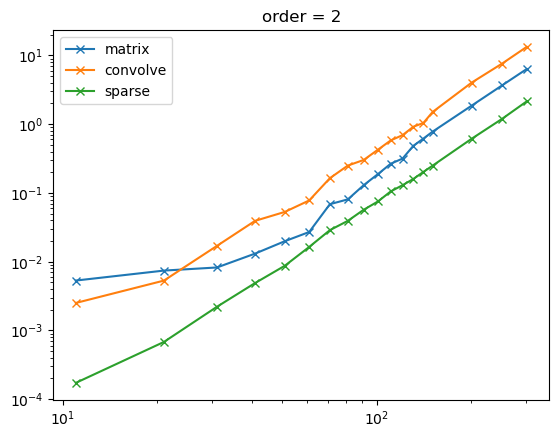

In [48]:
import matplotlib.pyplot as plt
plt.figure()
plt.loglog(n_range, time_matrix, 'x-', label='matrix')
plt.loglog(n_range, time_convolve, 'x-', label='convolve')
plt.loglog(n_range, time_sparse, 'x-', label='sparse')
plt.legend()
plt.title('order = 2')
plt.show()


In [49]:
for i in range(len(n_range)):
    n = n_range[i]
    ic(n)
    time_matrix[i], time_convolve[i], time_sparse[i] = timing(n,order=6)

ic| n: 11
ic| time_matrix: 0.0065307909389957786
    time_convolve: 0.004067625035531819
    time_sparse: 0.00033816706854850054
ic| n: 21
ic| time_matrix: 0.007234958931803703
    time_convolve: 0.007641749922186136
    time_sparse: 0.0014545839512720704
ic| n: 31
ic| time_matrix: 0.008104083011858165
    time_convolve: 0.01855383301153779
    time_sparse: 0.004613499972037971
ic| n: 41
ic| time_matrix: 0.012317792046815157
    time_convolve: 0.03580316691659391
    time_sparse: 0.010527875041589141
ic| n: 51
ic| time_matrix: 0.026067125028930604
    time_convolve: 0.07357187499292195
    time_sparse: 0.021103208069689572
ic| n: 61
ic| time_matrix: 0.04514999990351498
    time_convolve: 0.12564758397638798
    time_sparse: 0.03893933293875307
ic| n: 71
ic| time_matrix: 0.07390875008422881
    time_convolve: 0.17723183298949152
    time_sparse: 0.06105145800393075
ic| n: 81
ic| time_matrix: 0.1216086660278961
    time_convolve: 0.30187016702257097
    time_sparse: 0.09471133293118328
i

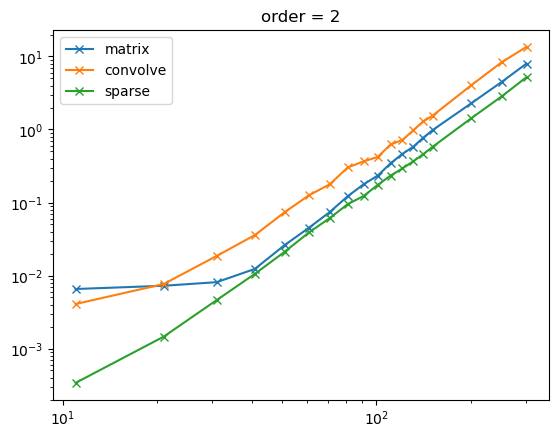

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.loglog(n_range, time_matrix, 'x-', label='matrix')
plt.loglog(n_range, time_convolve, 'x-', label='convolve')
plt.loglog(n_range, time_sparse, 'x-', label='sparse')
plt.legend()
plt.title('order = 2')
plt.show()


In [49]:
# find lowest eigenvalue using inverse iterations with conjugate gradients
from scipy.sparse.linalg import LinearOperator, cg
sigma = -0.5
M = LinearOperator((len(x), len(x)), matvec=lambda v: H.dot(v) - sigma*v)

# for k in range(15):
#     psi, _ = cg(M, psi, tol=1e-8)
#     psi /= psi.dot(psi)**.5
#     E = psi.dot(H.dot(psi))
#     ic(E)
    
psi_ground_state = psi.copy()

In [50]:
from scipy.sparse.linalg import gmres

dt = 0.01
I = identity(H.shape[0])
A = I + 0.5j * dt * H
    
def cn_step(psi, dt, H):
    """Perform a single step of the Crank-Nicolson method.

    Parameters
    ----------
    psi : numpy.ndarray
        The wave function at the current time step.
    dt : float
        The time step size.
    H : scipy.sparse.csr_matrix
        The Hamiltonian operator.

    Returns
    -------
    numpy.ndarray
        The wave function at the next time step.
    """
#    I = identity(H.shape[0])
#    A = I + 0.5j * dt * H
    #b = (I - 0.5j * dt * H).dot(psi)
    b = psi - 0.5j * dt * H.dot(psi)
    psi_next, _ = gmres(A, b, tol=1e-10)
    return psi_next

from scipy.sparse.linalg import expm_multiply

X = -0.5j * dt * H
def exp_step(psi):
    return expm_multiply(X, psi)


In [36]:
for k in range(10):
    psi = cn_step(psi, 0.01, H)
    ic(np.linalg.norm(psi))

ic| np.linalg.norm(psi): 0.9999999999997129
ic| np.linalg.norm(psi): 0.9999999999994467
ic| np.linalg.norm(psi): 0.9999999999991769
ic| np.linalg.norm(psi): 0.9999999999988504
ic| np.linalg.norm(psi): 0.99999999999856
ic| np.linalg.norm(psi): 0.9999999999983651
ic| np.linalg.norm(psi): 0.9999999999980431
ic| np.linalg.norm(psi): 0.999999999997699
ic| np.linalg.norm(psi): 0.9999999999975183
ic| np.linalg.norm(psi): 0.99999999999725


In [37]:
for k in range(10):
    psi = exp_step(psi)
    ic(np.linalg.norm(psi))

ic| np.linalg.norm(psi): 0.999999999997237
ic| np.linalg.norm(psi): 0.9999999999972169
ic| np.linalg.norm(psi): 0.9999999999972204
ic| np.linalg.norm(psi): 0.9999999999972091
ic| np.linalg.norm(psi): 0.9999999999972189
ic| np.linalg.norm(psi): 0.9999999999972109
ic| np.linalg.norm(psi): 0.9999999999972323
ic| np.linalg.norm(psi): 0.9999999999972343
ic| np.linalg.norm(psi): 0.9999999999972143
ic| np.linalg.norm(psi): 0.9999999999972126


In [42]:
psi2 = apply_hamiltonian(psi)
np.sum(psi2 * psi)

-0.5333824797752227

In [43]:
L[:3,:3].todense()

matrix([[-16.66666667,   2.77777778,   0.        ],
        [  2.77777778, -16.66666667,   2.77777778],
        [  0.        ,   2.77777778, -16.66666667]])

In [44]:
help(convolve)

Help on function convolve in module scipy.signal._signaltools:

convolve(in1, in2, mode='full', method='auto')
    Convolve two N-dimensional arrays.
    
    Convolve `in1` and `in2`, with the output size determined by the
    `mode` argument.
    
    Parameters
    ----------
    in1 : array_like
        First input.
    in2 : array_like
        Second input. Should have the same number of dimensions as `in1`.
    mode : str {'full', 'valid', 'same'}, optional
        A string indicating the size of the output:
    
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        ``same``
           The output is the same size as `in1`, centered
           with respect to the 'full' output.
    metho

In [45]:
L1, x0 = fdm_laplacian_1d(-15,15, n, order=2)

L1

<51x51 sparse matrix of type '<class 'numpy.float64'>'
	with 151 stored elements (3 diagonals) in DIAgonal format>

In [17]:
apply_hamiltonian_as_matrix(psi_grid)

array([[[ 9.76819954e-13+2.42140904e-12j,
          1.59810443e-12-6.03940616e-12j,
         -4.37961065e-12+4.48977231e-12j, ...,
         -4.37960907e-12+4.48976471e-12j,
          1.59810246e-12-6.03939565e-12j,
          9.76821077e-13+2.42140161e-12j],
        [ 1.59810476e-12-6.03940712e-12j,
         -3.62792842e-12+6.44518462e-12j,
          1.34561980e-12+1.75470888e-12j, ...,
          1.34561848e-12+1.75471936e-12j,
         -3.62792567e-12+6.44516939e-12j,
          1.59810250e-12-6.03939568e-12j],
        [-4.37961129e-12+4.48977428e-12j,
          1.34562034e-12+1.75470716e-12j,
          4.77708593e-12-9.95212812e-12j, ...,
          4.77708636e-12-9.95213659e-12j,
          1.34561839e-12+1.75471964e-12j,
         -4.37960912e-12+4.48976449e-12j],
        ...,
        [-4.37961163e-12+4.48977413e-12j,
          1.34562108e-12+1.75470825e-12j,
          4.77708603e-12-9.95213137e-12j, ...,
          4.77708571e-12-9.95212779e-12j,
          1.34561955e-12+1.75470983e-12j

In [15]:
help(timeit.timeit)

Help on function timeit in module timeit:

timeit(stmt='pass', setup='pass', timer=<built-in function perf_counter>, number=1000000, globals=None)
    Convenience function to create Timer object and call timeit method.

